In [1]:
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

# others
from funciones_limpieza import *
from utils_aprendizaje_no_supervisado import * 
from funciones_clasificacion import *
from funciones_seriestemporales import *

# Carga de los CSVs

In [2]:
# ---------------------
# 1. Definir carpetas
# ---------------------
carpeta_myrtle = "./Join_plots_alarmas"
carpeta_sigma = "./Join_plots_alarmas_Sigma"

# ---------------------
# 2. Obtener lista de CSVs
# ---------------------
archivos = []
for carpeta in [carpeta_myrtle, carpeta_sigma]:
    archivos += [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith(".csv")]

print(f"Total de archivos (inversores): {len(archivos)}")

# ---------------------
# 3. Leer y unir todos 
# ---------------------
dfs_global = []
for f in archivos:
    nombre_inversor = os.path.splitext(os.path.basename(f))[0]  # sin extensión
    df = pd.read_csv(f)
    df['FechaHora'] = pd.to_datetime(df['FechaHora'])
    df['inversor_id'] = nombre_inversor
    df['Condensacion'] = df['Condensacion'].astype('category')
    dfs_global.append(df)

df_global = pd.concat(dfs_global, ignore_index=True)

print(f"Shape del DataFrame global: {df_global.shape}")
print(df_global[['inversor_id']].value_counts())  # Ver cuantos registros por inversor




Total de archivos (inversores): 72
Shape del DataFrame global: (3110328, 47)
inversor_id 
10.144.51.1     86398
10.144.51.15    86398
10.144.51.52    43199
10.144.51.58    43199
10.144.51.57    43199
                ...  
10.144.51.38    43199
10.144.51.39    43199
10.144.51.40    43199
10.144.51.41    43199
F1              43199
Name: count, Length: 70, dtype: int64


In [3]:
df_global.head(5)

,FechaHora,utc,sample,PPC_PMG,PPC_QMG,PMG_M,QMG_M,UL1_RMS,UL2_RMS,UL3_RMS,...,TAIR_OUTLET,THFILTER,DPF_HUM_INT,DPF_TEMP_INT,T_SKIIP_MIN,TPOT_CAB_MAX,T_LIQ_MIN,DELTA_TEMP_AMB,Condensacion,inversor_id
0,2025-03-04 17:06:36,1741107996,489289,2119000.0,-221000.0,1811659.375,-220927.921875,394.721710,395.049500,392.994202,...,41.483582,65.209633,0.0,0.0,55.265743,37.059196,46.553570,18.206547,0,10.144.51.1
1,2025-03-04 17:06:38,1741107998,489290,2119000.0,-221000.0,1810197.625,-220975.453125,393.673920,395.729004,393.751038,...,41.792809,65.209633,0.0,0.0,55.006611,37.059196,46.242649,17.947415,0,10.144.51.1
2,2025-03-04 17:06:40,1741108000,489291,2119000.0,-221000.0,1809587.875,-221461.906250,394.780640,395.074371,392.956909,...,41.483582,65.209633,0.0,0.0,55.257862,37.059196,46.242649,18.198666,0,10.144.51.1
3,2025-03-04 17:06:42,1741108002,489292,2119000.0,-221000.0,1812199.125,-221418.562500,393.758514,395.865723,393.824829,...,41.483582,65.209633,0.0,0.0,55.265255,37.059196,46.242649,18.206059,0,10.144.51.1
4,2025-03-04 17:06:44,1741108004,489293,2119000.0,-221000.0,1812691.500,-220925.265625,393.510468,395.651581,393.602936,...,41.792217,65.209633,0.0,0.0,55.256668,37.059196,46.553570,18.197472,0,10.144.51.1


# EXPLORATORY DATA ANALYSIS

In [22]:
df_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3110328 entries, 0 to 3110327
Data columns (total 47 columns):
 #   Column          Dtype         
---  ------          -----         
 0   FechaHora       datetime64[ns]
 1   utc             int64         
 2   sample          int64         
 3   PPC_PMG         float64       
 4   PPC_QMG         float64       
 5   PMG_M           float64       
 6   QMG_M           float64       
 7   UL1_RMS         float64       
 8   UL2_RMS         float64       
 9   UL3_RMS         float64       
 10  IT1_RMS         float64       
 11  IT2_RMS         float64       
 12  IT3_RMS         float64       
 13  UDC1_FIL        float64       
 14  UDC2_FIL        float64       
 15  VPV1_FIL        float64       
 16  VPV2_FIL        float64       
 17  TSOC            float64       
 18  TCCU            float64       
 19  TEXTERIOR       float64       
 20  TCAB_AC         float64       
 21  TCAB_POT1       float64       
 22  TCAB_POT2       fl

In [24]:
df_global.describe().T

#Todas las columnas tienen el mismo número de registros (3.110.328) por lo que no hay valores faltantes.

# - DPF_HUM_INT y DPF_TEMP_INT solo tienen valor nulo
# - PPC_PMG y PPC_QMG tienen un rango amplio de valores con una desviación estándar elevada
# - PMG_M tiene un rango bastante amplio de valores el 75% de los datos son menores que 3822054.625 mientras que el máximo es de 4696438.5	 por lo 
#   que es probable la presencia de outliers
# - QMG_M tiene un rango bastante amplio de valores el 75% de los datos son menores que 99449.580078 mientras que el máximo es de 99449.580078 por lo 
#   que es probable la presencia de outliers
# - UL1_RMS, UL2_RMS, UL3_RMS tienen rangos de valores no muy grandes
# - IT1_RMS, IT2_RMS, IT3_RMS tienen rango de valores bastante elevado (en especial IT3_RMS). Mucha diferencia entre el valor del tercer cuartil 
#   al máximo en IT3_RMS puede demostrar presencia de outliers (valores anómalos quizá por comportamiento anómalo) 
# - UDC1_FIL, UDC2_FIL valores algo dispersos con métricas bastante parecidas
# - VPV1_FIL, VPV2_FIL  tienen algo de variabilidad y cierta diferencia entre el tercer cuartil y el máximo (estos valores situados en ese rango 
#   quizá nos dan información de situaciones extremas)
# - TSOC, TCCU, TEXTERIOR, TCAB_AC, TCAB_POT1, TCAB_POT2, TDC_FUSES (información de temperaturas ambiente). Sin mucha dispersión en los datos
# - TBRID11, TBRID12, TBRID13, TBRID21, TBRID22, TBRID23 (info temperatura Skiip) tienen rangos muy parecidos sin mucha dispersión 
# - TCOILIND1, TCOILIND2, TCOREIND1, TCOREIND1 (info temperatura de inductancia) tienen rangos no muy amplios y similares dos a dos
# - TCOOLINGI, TCOOLINGO rangos parecidos sin mucha variabilidad
# - TAIR_INLET, TAIR_OUTLET rangos parecidos sin mucha variabilidad
# - THFILTER rango no muy amplio con un baja variabilidad
# - T_SKIIP_MIN rango no muy amplio con un baja variabilidad (VEMOS QUE EL VALOR MÍNIMP ESTÁ MUY PRÓXIMO A 31ºC LO QUE CUADRA CON EL
#   PROBLEMA DE CONDENSACIÓN
# - TPOT_CAB_MAX rango no muy amplio con un baja variabilidad
# - T_LIQ_MIN rango no muy amplio con un baja variabilidad
# - DELTA_TEMP_AMB rango no muy amplio con un baja variabilidad. COMO EL VALOR MÍNIMO ES NEGATIVO, TENEMOS INVERSORES CON FALLO DE CONDENSACIÓN
# - Condensacion como la media es 0.083333 vemos que la mayoría de inversores no se han etiquetado como fallo por condensación

,count,mean,min,25%,50%,75%,max,std
FechaHora,3110328,2025-10-07 12:01:09.643377152,2021-02-19 13:18:40,2025-03-04 18:00:43,2025-03-05 01:44:14,2025-03-05 09:59:54,2079-03-19 13:54:13,NaN
utc,3110328.0,1759838469.643378,1613740720.0,1741111243.0,1741139054.0,1741168794.0,3446459653.0,201742136.630659
sample,3110328.0,1615822.930556,151287.0,935807.0,1729009.5,2173330.25,3921988.0,876964.395895
PPC_PMG,3110328.0,1696577.27513,-29000.0,309000.0,318000.0,4048000.0,4709000.0,1879979.907255
PPC_QMG,3110328.0,15252.148005,-2885000.0,0.0,0.0,103000.0,221000.0,133007.709035
PMG_M,3110328.0,1458322.773472,-467088.09375,-8920.56543,-4052.159912,3822054.625,4696438.5,1890193.442696
QMG_M,3110328.0,15122.988442,-1472257.75,-387.801712,-16.746389,99449.580078,377349.15625,126797.399716
UL1_RMS,3110328.0,395.489704,367.183197,394.845146,396.046539,397.206726,409.073792,3.377815
UL2_RMS,3110328.0,396.785558,364.715576,395.962555,397.059509,399.145721,405.771667,4.281677
UL3_RMS,3110328.0,395.327609,360.445007,393.888855,396.12114,397.857758,400.478271,3.72649


In [4]:
columnas_a_dibujar = ['PPC_PMG', 'PPC_QMG', 'PMG_M', 'QMG_M', 'UL1_RMS', 'UL2_RMS', 'UL3_RMS', 'IT1_RMS', 'IT2_RMS',
                'IT3_RMS', 'UDC1_FIL', 'UDC2_FIL', 'VPV1_FIL', 'VPV2_FIL', 'TSOC', 'TCCU','TEXTERIOR', 'TCAB_AC','TCAB_POT1', 'TCAB_POT2',
                'TDC_FUSES', 'TBRID11', 'TBRID12', 'TBRID13', 'TBRID21', 'TBRID22', 'TBRID23', 'TCOILIND1', 'TCOILIND2', 'TCOREIND1', 
                'TCOREIND2', 'TCOOLINGI', 'TCOOLINGO', 'TAIR_INLET', 'TAIR_OUTLET', 'THFILTER', 'DPF_HUM_INT', 'DPF_TEMP_INT',
                'T_SKIIP_MIN', 'TPOT_CAB_MAX', 'T_LIQ_MIN', 'DELTA_TEMP_AMB', 'Condensacion'
                      
             ]

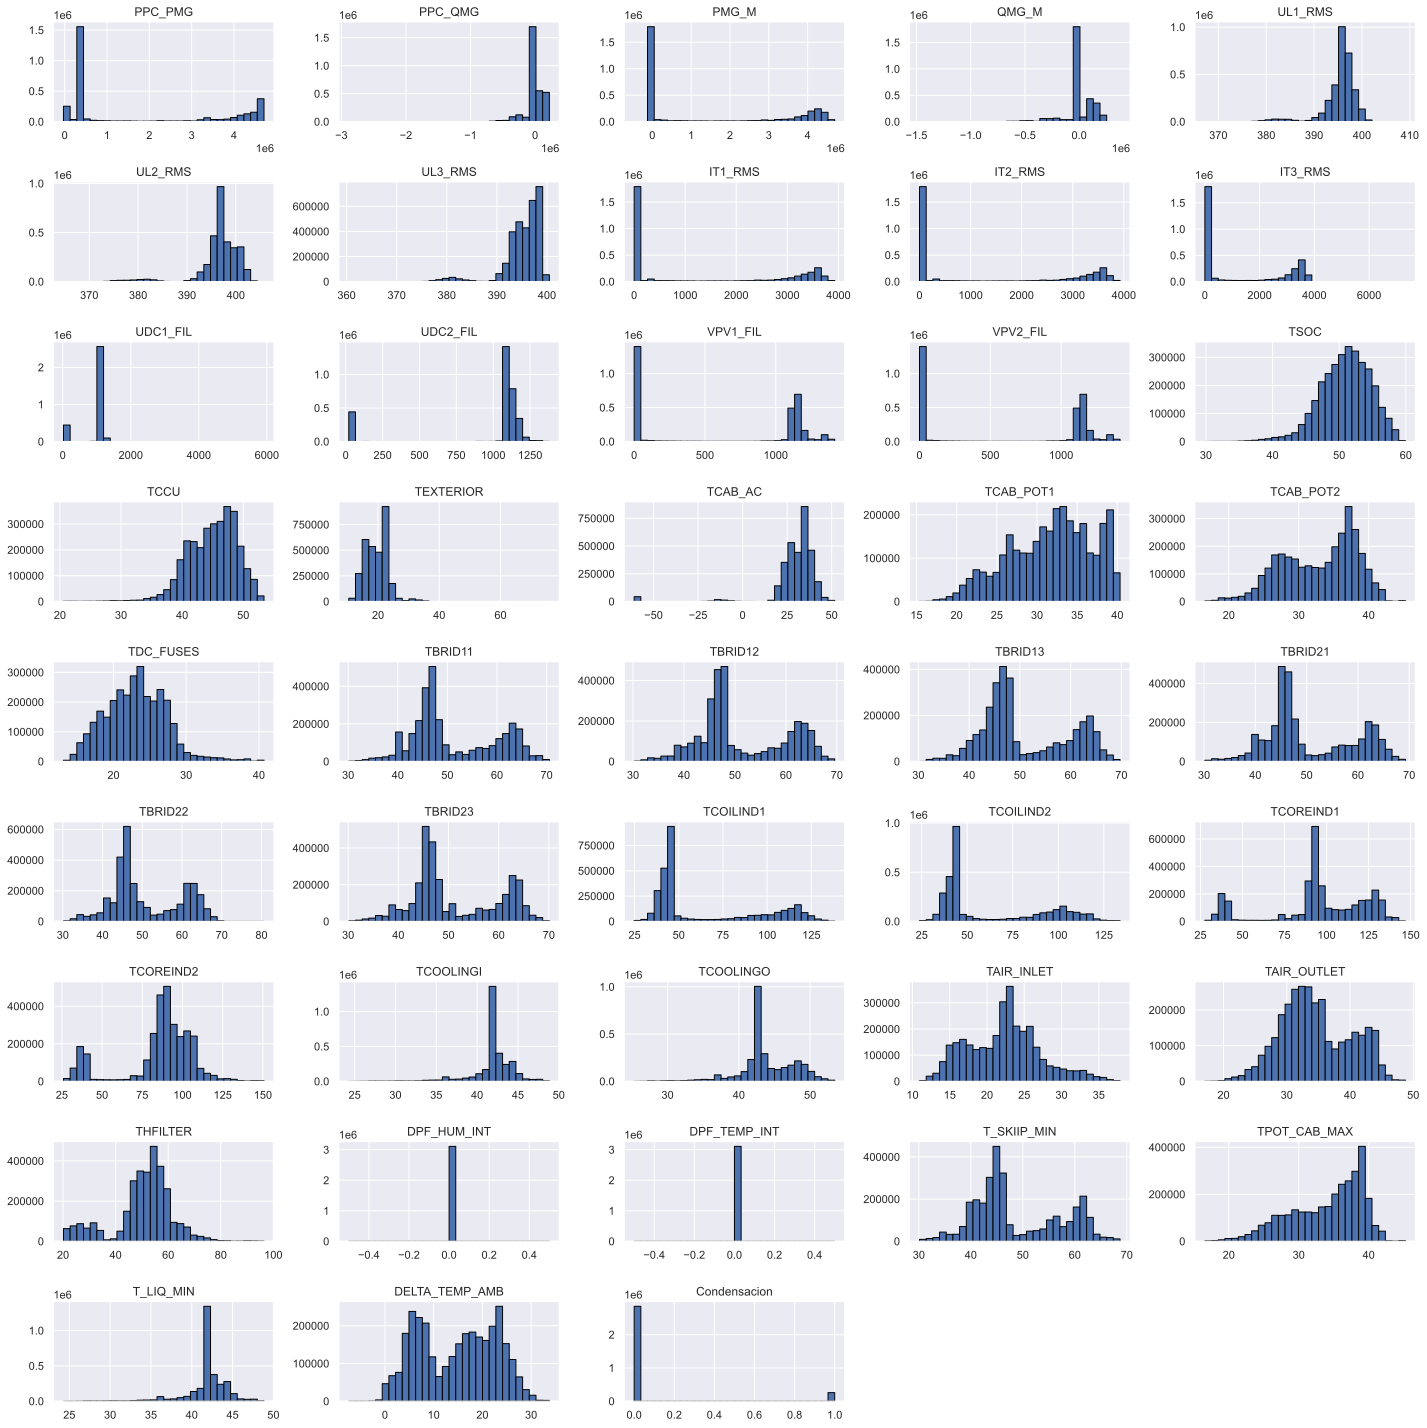

In [25]:
#No realizo el histograma de time, utc ni sample pues no aporta información relevante
columnas_a_dibujar = ['PPC_PMG', 'PPC_QMG', 'PMG_M', 'QMG_M', 'UL1_RMS', 'UL2_RMS', 'UL3_RMS', 'IT1_RMS', 'IT2_RMS',
                'IT3_RMS', 'UDC1_FIL', 'UDC2_FIL', 'VPV1_FIL', 'VPV2_FIL', 'TSOC', 'TCCU','TEXTERIOR', 'TCAB_AC','TCAB_POT1', 'TCAB_POT2',
                'TDC_FUSES', 'TBRID11', 'TBRID12', 'TBRID13', 'TBRID21', 'TBRID22', 'TBRID23', 'TCOILIND1', 'TCOILIND2', 'TCOREIND1', 
                'TCOREIND2', 'TCOOLINGI', 'TCOOLINGO', 'TAIR_INLET', 'TAIR_OUTLET', 'THFILTER', 'DPF_HUM_INT', 'DPF_TEMP_INT',
                'T_SKIIP_MIN', 'TPOT_CAB_MAX', 'T_LIQ_MIN', 'DELTA_TEMP_AMB', 'Condensacion'
                      
             ]
# Ajustar el tamaño de la figura y la distribución de subgráficos
df_global[columnas_a_dibujar].hist(figsize=(20, 20), bins=30, layout=(9, 5), edgecolor='black')

plt.tight_layout()  # Ajusta los espacios entre gráficos
plt.savefig('./img_EDA/histogramas.png')
plt.show()	

In [5]:
def boxplots(df, cols=None, ruta='./img_EDA/boxplots'):
    """
    Función que dado un dataframe df grafica los boxplots para las columnas especificadas o 
    para todas las columnas numéricas si no se especifica ninguna. Además, muestra la media 
    de esa columna en el boxplot con una línea discontinua.
    
    Parámetros:
    - df: pandas.DataFrame
    - cols: lista de nombres de columnas a graficar (opcional)
    - ruta: ruta donde se guarda la imagen generada
    """
    if cols is None:
        # Seleccionar solo las columnas numéricas si no se especifican
        columnas = df.select_dtypes(include=['number']).columns
    else:
        # Validar que las columnas existen en el DataFrame
        columnas = [col for col in cols if col in df.columns]
        if not columnas:
            print("No se especificaron columnas válidas.")
            return

    num_cols = len(columnas)
    num_filas = int(np.ceil(num_cols / 4))
    num_columnas = min(num_cols, 4)  # Máximo 4 columnas por fila

    plt.figure(figsize=(10 * num_columnas, 6 * num_filas))

    for i, col in enumerate(columnas):
        plt.subplot(num_filas, num_columnas, i + 1)
        ax = sns.boxplot(x=df[col])

        media = df[col].mean()
        plt.axvline(media, color='black', linestyle='--', linewidth=1, label='Media')

        if i == 0:
            ax.legend(loc='upper right', fontsize=10, title='Líneas')

        plt.title(f'Boxplot de {col}')

    plt.tight_layout()
    os.makedirs(os.path.dirname(ruta), exist_ok=True)
    plt.savefig(ruta)
    print(f"Gráfico guardado en: {ruta}")
    plt.show()




boxplots(df_global, cols = columnas_a_dibujar)

#Centrándome en el problema de condensación, tenemos outliers potenciales en TPOT_CAB_MAX (valores por debajo de 15) y T_LIQ_MIN (muchos 
#valores entre 25 y 40)

Gráfico guardado en: ./img_EDA/boxplots


KeyboardInterrupt: 

Columnas no numéricas en el DataFrame original:
Index(['FechaHora', 'inversor_id'], dtype='object')
Gráfico guardado en: ./img_EDA/matriz_correlacion


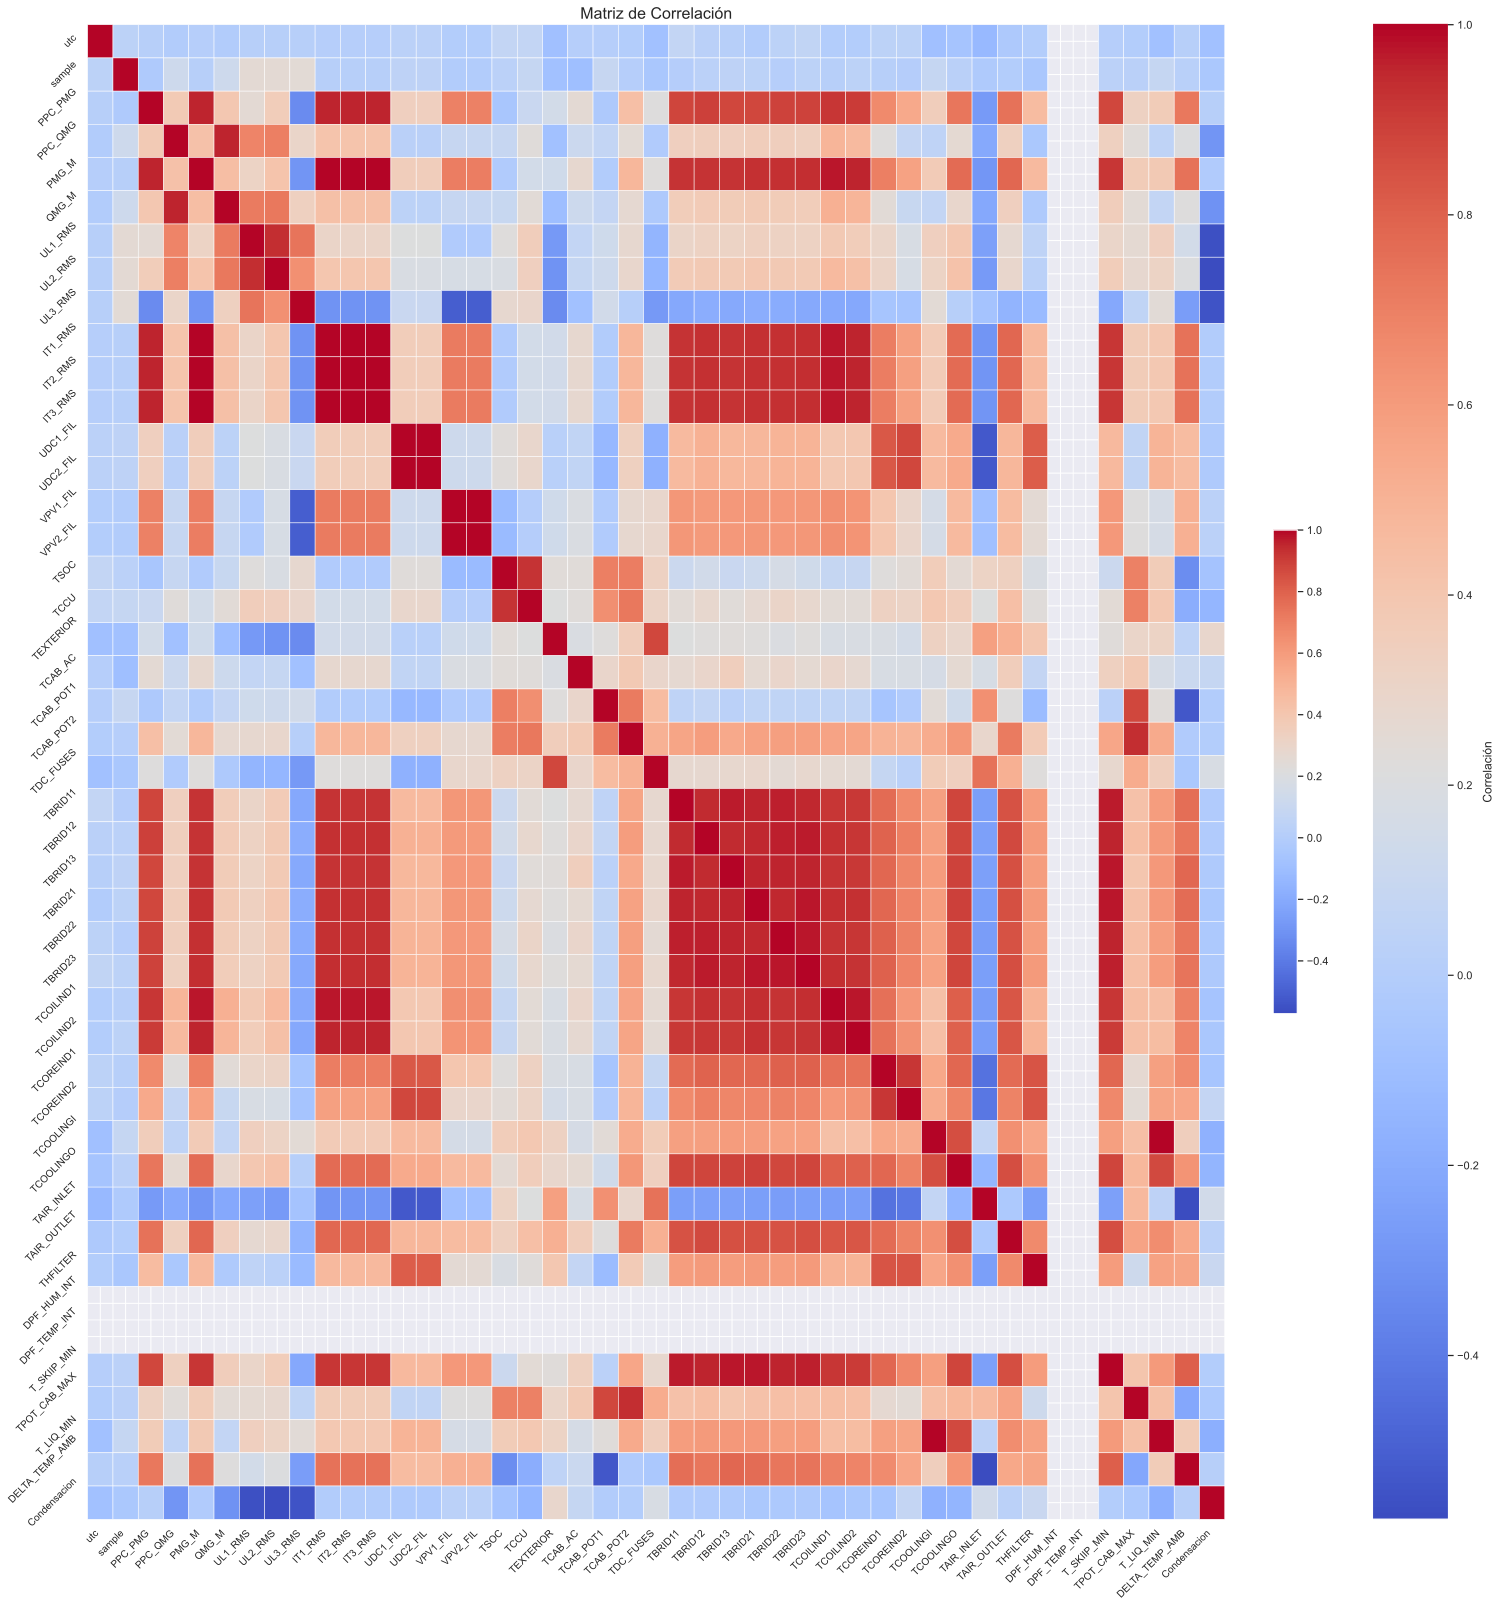

In [15]:

def matriz_correlacion(df, ruta = './img_EDA/matriz_correlacion'):
    # Seleccionar solo las columnas numéricas
    df_numerico = df.select_dtypes(include=['number'])
    
    # Mostrar las columnas que no están en df_numerico
    columnas_no_numericas = df.columns.difference(df_numerico.columns)
    print("Columnas no numéricas en el DataFrame original:")
    print(columnas_no_numericas)
    
    # Calcular la matriz de correlación
    correlacion = df_numerico.corr()
    
    # Crear una máscara para los valores NaN
    mask_nan = correlacion.isna()  # Esto será un DataFrame con True donde hay NaN
    
    # Reemplazar NaN con un valor específico para que el heatmap lo pueda dibujar
    correlacion_filled = correlacion.fillna(-1)  # -1 será el valor temporal para los NaN
    
    # Calcular el tamaño de la figura en función del número de columnas
    num_cols = len(df_numerico.columns)
    
    # Ajustar el tamaño dinámicamente según la cantidad de columnas
    fig_size = (num_cols * 0.5, num_cols * 0.5)  # Tamaño ajustado de la figura
    
    # Crear el gráfico
    plt.figure(figsize=fig_size)
    
    # Dibujar el heatmap, usando un color específico para los NaN
    ax = sns.heatmap(correlacion_filled, annot=False, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Correlación'},
                     xticklabels=correlacion.columns, yticklabels=correlacion.columns, mask=mask_nan)
    
    # Añadir título
    plt.title("Matriz de Correlación", fontsize=16)
    
    # Ajustar las etiquetas para que no se solapen
    plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotar las etiquetas del eje x
    plt.yticks(rotation=45, ha='right', fontsize=10)  # Rotar las etiquetas del eje y
    
    # Ajustar el diseño para evitar que se solapen
    plt.tight_layout()
    
    # Ajustar la posición de la barra de color (colorbar)
    plt.colorbar(ax.collections[0], ax=ax, fraction=0.02, pad=0.04)  # Ajustar la barra de color

    #Guardar gráfico
    os.makedirs(os.path.dirname(ruta), exist_ok=True) #asegurar que la carpeta existe 
    plt.savefig(ruta) 
    print(f"Gráfico guardado en: {ruta}")
    
    # Mostrar el gráfico
    plt.show()


matriz_correlacion(df_global)

#Observamos que tenemos valores Nan en las correlaciones de las columnas DPF_HUM_INT y DPF_TEMP_INT. Esto se debe a que estas columnas tienen
#un único valor por lo que su desviación estándar es cero y la correlación, como implica dividir por esta desviación, nos devuelve Nan.

#Centrándonos en el problema de condensación vemos que DELTA_TEMP_AMB tiene alta correlación con T_SKIIP_MIN y baj con T_POT_CAB_MAX. DELTA_TEMP_AMB
#tiene elevadas correlaciones con las variables de temperatura, de corriente (IT1, IT2, IT3) y con algunas de potencia  activa (PMG_M y PPC_PMG)

In [16]:

def variables_altamente_correlacionadas(df, umbral=0.95):
    """
    Dado un df y un umbral (por defecto es 0.8) devuelve un array de arrays. Cada subarray es un grupo de variables que tiene una correlación
    igual o superior entre ellas. 
    Para el proceso de creación de estos subarrays, estamos aplicando la correlación transitiva, es decir, si las variables A y B están 
    altamente correlacionadas entre si y las variables B y C están altamente correlacionadas entonces las variables A y C también lo estarán.
    """
    # Seleccionar solo las columnas numéricas
    df_numerico = df.select_dtypes(include=['number'])
    
    # Calcular la matriz de correlación
    correlacion = df_numerico.corr()
    
    # Inicializar una lista para almacenar los grupos de variables correlacionadas
    grupos_correlacionados = []
    
    # Crear un conjunto para hacer un seguimiento de las variables ya agrupadas
    ya_agrupadas = set()

    # Recorrer la matriz de correlación para encontrar correlaciones altas
    for i in range(len(correlacion.columns)):
        for j in range(i):
            if abs(correlacion.iloc[i, j]) >= umbral:
                # Si las variables no están ya agrupadas, se crea un nuevo grupo
                if correlacion.columns[i] not in ya_agrupadas and correlacion.columns[j] not in ya_agrupadas:
                    grupo = {correlacion.columns[i], correlacion.columns[j]}
                    ya_agrupadas.update(grupo)
                    grupos_correlacionados.append(list(grupo))
                # Si solo una de las variables está agrupada, agregamos la otra a ese grupo
                elif correlacion.columns[i] in ya_agrupadas and correlacion.columns[j] not in ya_agrupadas:
                    ya_agrupadas.add(correlacion.columns[j])
                    grupos_correlacionados[-1].append(correlacion.columns[j])
                elif correlacion.columns[j] in ya_agrupadas and correlacion.columns[i] not in ya_agrupadas:
                    ya_agrupadas.add(correlacion.columns[i])
                    grupos_correlacionados[-1].append(correlacion.columns[i])
                
                # En este punto, verificamos si alguna de las variables está relacionada con otras ya agrupadas
                # Si alguna de las dos está en un grupo existente, las añadimos a ese grupo.
                for grupo in grupos_correlacionados:
                    if correlacion.columns[i] in grupo and correlacion.columns[j] not in grupo:
                        grupo.append(correlacion.columns[j])
                        ya_agrupadas.add(correlacion.columns[j])
                    elif correlacion.columns[j] in grupo and correlacion.columns[i] not in grupo:
                        grupo.append(correlacion.columns[i])
                        ya_agrupadas.add(correlacion.columns[i])

    # Eliminar subgrupos de tamaño 1 
    grupos_correlacionados = [grupo for grupo in grupos_correlacionados if len(grupo) > 1]

    return grupos_correlacionados

var_muy_correlacionadas = variables_altamente_correlacionadas(df_global)
var_muy_correlacionadas

[['PMG_M',
  'PPC_PMG',
  'IT1_RMS',
  'IT2_RMS',
  'IT3_RMS',
  'TCOILIND1',
  'TCOILIND2'],
 ['QMG_M',
  'PPC_QMG',
  'IT1_RMS',
  'PPC_PMG',
  'PMG_M',
  'IT2_RMS',
  'IT3_RMS',
  'TCOILIND1',
  'TCOILIND2'],
 ['UDC1_FIL', 'UDC2_FIL'],
 ['VPV2_FIL', 'VPV1_FIL'],
 ['TBRID13',
  'TBRID11',
  'TBRID21',
  'TBRID22',
  'TBRID12',
  'TBRID23',
  'TCOILIND1',
  'PMG_M',
  'IT1_RMS',
  'IT2_RMS',
  'IT3_RMS',
  'TCOILIND2',
  'T_SKIIP_MIN'],
 ['TCOOLINGI', 'T_LIQ_MIN']]

In [29]:
#PAIPLOT DE DELTA_TEMP_AMB CON LAS VARIABLES MÁS ALTAMENTE CORRELACIONADAS (muy costoso tanto en local como en colab)
correlaciones = df_global.corr(numeric_only=True)['DELTA_TEMP_AMB'].abs().sort_values(ascending=False)
#variables_top = correlaciones.index[1:6]  # Excluye DELTA_TEMP_AMB consigo misma

#sns.pairplot(df_global[variables_top.tolist() + ['DELTA_TEMP_AMB', 'Condensacion']], 
#             hue='Condensacion',
#             plot_kws={'alpha': 0.6})
print(correlaciones)

DELTA_TEMP_AMB    1.000000
T_SKIIP_MIN       0.804667
TBRID13           0.781940
TBRID21           0.763626
TBRID11           0.759254
IT2_RMS           0.745230
IT1_RMS           0.745160
IT3_RMS           0.745082
PMG_M             0.742453
TBRID23           0.741095
TBRID22           0.735793
TBRID12           0.732991
PPC_PMG           0.724869
TCOILIND1         0.692927
TCOILIND2         0.685725
TCOREIND1         0.659491
TCOOLINGO         0.631008
TAIR_INLET        0.568844
THFILTER          0.560298
TCOREIND2         0.552572
TAIR_OUTLET       0.548387
TCAB_POT1         0.532174
VPV1_FIL          0.510057
VPV2_FIL          0.510057
UDC2_FIL          0.458696
UDC1_FIL          0.458690
T_LIQ_MIN         0.361574
TCOOLINGI         0.343546
TSOC              0.328971
UL3_RMS           0.264550
TPOT_CAB_MAX      0.216152
QMG_M             0.214908
UL2_RMS           0.207559
PPC_QMG           0.203254
TCCU              0.189206
UL1_RMS           0.146558
TCAB_AC           0.105591
T